## 1. Разбиение выборки

**Разбиение выборки** - это разделение имеющихся данных на несколько частей для проведения процессов обучения и валидации алгоритма машинного обучения таким образом, чтобы оба процесса выполнялись на полностью независимых наборах данных (чтобы при валидации алгоритм работал с полностью незнакомыми данными той же структуры, что и обучающий набор данных).

### Какие бывают выборки

- [Тренировочная выборка](https://developers.google.com/machine-learning/glossary/#training_set) - подмножество данных, на котором тренируется модель
- [Валидационная выборка](https://developers.google.com/machine-learning/glossary/#validation_set) - подмножество данных, на котором модель настраивается ("тюнится", подгоняются параметры)
- [Тестовая выборка](https://developers.google.com/machine-learning/glossary/#test_set) - подмножество данных, на котором тестируется модель после проверки всех возможных гипотез по улучшению модели

### Способы разбиения выборки

1. **hold-out** (отложенная выборка)
1. **k-fold** (cross-validation, перекрестная валидация)
1. **leave-one-out** (отложенный пример)

### 1.1. hold-out разбиение

**hold-out** разбиение — исходная выборка разбивается на обучающую и валидационную (+ опционально на тестовую) части в некотором соотношении.

Крайне рекомендуемая практика — разбивать выборку на **train/valid/test**. Причина выделения независимой тестовой выборки в том, что она не затрагивается до момента разворачивания алгоритма в сервисе и, соответственно, не используется при настройке параметров алгоритма. Тестирование в таком случае происходит честным путем — полученная на тестовой выборке метрика будет максимально близка к фактически посчитанной метрике в "боевых условиях".

Мы в дальнейшем будем разбивать выборку на train/valid для упрощения разбора материала.  

В каком соотношении делать разбиение?
Обычно **на валидационную выборку выделяют по 20-40% данных**. При выделении дополнительно тестовой выборки разбиение можно провести в соотношении **60/20/20%, либо 70/15/15%**. Реальные доли определяются исходя из наличия данных.

Для примера возьмем известный датасет ирисов. Скачать: https://archive.ics.uci.edu/ml/datasets/iris

<img src="./images/irises.jpeg" width="500" align="center">

[Источник изображения](https://medium.com/codebagng/basic-analysis-of-the-iris-data-set-using-python-2995618a6342)

In [1]:
import pandas as pd

In [4]:
iris_data = pd.read_csv('../data/iris.data', 
                        names=['sepal_length', 'sepal_width', 
                               'petal_length', 'petal_width', 'class'])

In [5]:
iris_data.head(10)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


Разобьем исходную выборку на две части: тренировочную и валидационную, используя scikit-learn метод [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, valid = train_test_split(iris_data, test_size=0.15, shuffle=True)

In [8]:
print('Размер исходной выборки: {}\nРазмер тренировочной выборки: {}\nРазмер валидационной выборки: {}'
      .format(iris_data.shape, train.shape, valid.shape)
)

Размер исходной выборки: (150, 5)
Размер тренировочной выборки: (127, 5)
Размер валидационной выборки: (23, 5)


In [9]:
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [10]:
def visualize_train_valid_counts(init_data, train, valid):
    x = np.array([0, 1, 2])
    width = 0.2

    plt.figure(figsize=(15, 8))
    ax = plt.subplot(111)

    classes = list(init_data['class'].value_counts().index)

    ax.bar(x - width, list(init_data['class'].value_counts()[classes]), width, color='r', label='Исходные данные')
    ax.bar(x, list(train['class'].value_counts()[classes]), width, color='g', label='Тренировочная выборка')
    ax.bar(x, list(valid['class'].value_counts()[classes]), width, bottom=list(train['class'].value_counts()[classes]), color='b', label='Валидационная выборка')

    ax.set_ylim([0, 70])
    plt.xticks(x - width / 2, classes, fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylabel('Кол-во примеров', fontsize=20)
    plt.minorticks_on()
    plt.grid(which='major', color='r')
    plt.grid(which='minor', linestyle=':', color='k')
    plt.legend(fontsize=15)

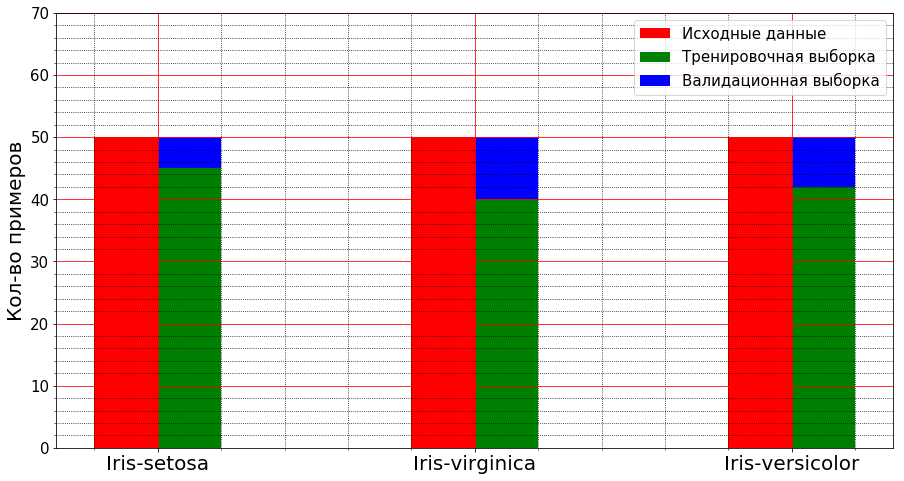

In [11]:
visualize_train_valid_counts(iris_data, train, valid)

По bar chart выше видно, что количество примеров каждого класса в тренировочной (или валидационной) выборке не совпадает. Это происходит потому, что мы разбили выборку без учета долей классов. Принцип, при котором данные разбиваются с учетом долей классов, называется **stratified** разбиение (стратифицированное разбиение).  
Для того чтобы сделать стратифицированное разбиение воспользуемся методом [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) из библиотеки scikit-learn:

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15)
train_indices, valid_indices = [split for split in sss.split(iris_data.iloc[:, :4], iris_data.iloc[:, 4])][0]
s_train = iris_data.iloc[train_indices]
s_valid = iris_data.iloc[valid_indices]

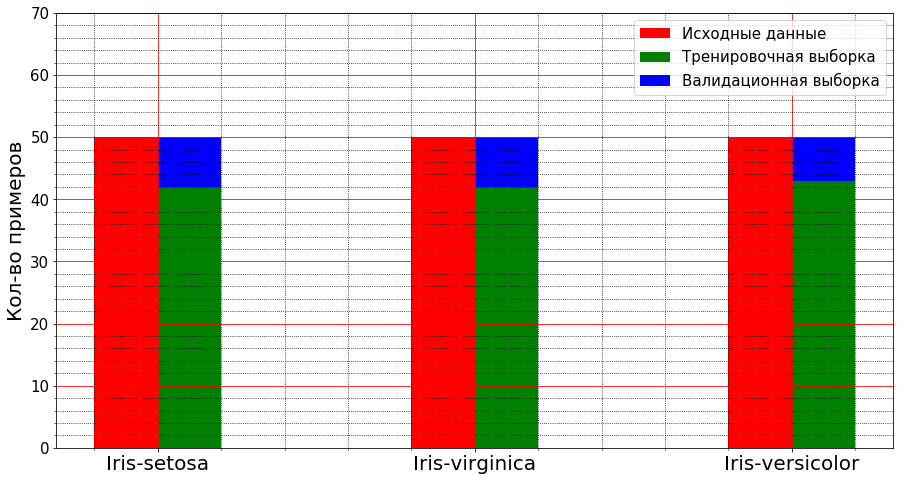

In [15]:
visualize_train_valid_counts(iris_data, s_train, s_valid)

#### 1.2. Разбиение на train/valid/test

In [16]:
valid_frac = 0.15
test_frac = 0.15

valid_count = int(valid_frac * iris_data.shape[0])
test_count = int(test_frac * iris_data.shape[0])

train, valid_test = train_test_split(iris_data, 
                                     test_size=(valid_count + test_count))
valid, test = train_test_split(valid_test, test_size=test_count)

In [17]:
print('Размер исходной выборки: {}\nРазмер тренировочной выборки: {}\n\
Размер валидационной выборки: {}\nРазмер тестовой выборки: {}'
      .format(iris_data.shape, train.shape, valid.shape, test.shape)
)

Размер исходной выборки: (150, 5)
Размер тренировочной выборки: (106, 5)
Размер валидационной выборки: (22, 5)
Размер тестовой выборки: (22, 5)


### 1.3. k-fold разбиение

[**Перекрестная проверка**](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BA%D1%80%D1%91%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0) (k-fold разбиение, скользящий контроль) — метод оценки поведения алгоритма на независимых данных, при котором исходная выборка разбивается на $k$ частей, на $k-1$ из которых производится обучение, а на $1$ валидация. В результате получается оценка эффективности выбранной модели с наиболее равномерным использованием имеющихся данных.

Сделаем k-fold разбиение данных, используя scikit-learn класс [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html):

In [18]:
from sklearn.model_selection import KFold

In [19]:
# shuffle=False исключает предварительное перемешивание примеров
kf = KFold(n_splits=3, shuffle=False)

In [20]:
for train_index, valid_index in kf.split(iris_data):
    print('train indices: {}\nvalid indices: {}'.format(train_index, valid_index))
    print('='*20)

train indices: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149]
valid indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
train indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 

### 1.4. leave-one-out разбиение

**leave-one-out** разбиение — разбиение, при котором в качестве обучающей выборки рассматриваются $n-1$ пример, а в качестве валидационной $1$ пример из исходной выборки.

Сделаем leave-one-out разбиение 5-ти примеров из исходных данных с помощью scikit-learn класса [LeaveOneOut](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html):

In [21]:
from sklearn.model_selection import LeaveOneOut

In [22]:
loo = LeaveOneOut()

In [23]:
for train_index, valid_index in loo.split(iris_data[:5]):
    print('train indices: {}\nvalid indices: {}'.format(train_index, valid_index))
    print('='*20)

train indices: [1 2 3 4]
valid indices: [0]
train indices: [0 2 3 4]
valid indices: [1]
train indices: [0 1 3 4]
valid indices: [2]
train indices: [0 1 2 4]
valid indices: [3]
train indices: [0 1 2 3]
valid indices: [4]


Leave-one-out разбиение это частный случай [Leave-P-out](https://en.wikipedia.org/wiki/Cross-validation_(statistics%29) разбиения, при котором составляются комбинации из $p$ примеров исходных данных. Количество всевозможных комбинаций при таком разбиении составляет $C^p_n$ (или$\binom{n}{p}$), что вынуждает отказаться от использования этого метода при средних и больших объемах данных.  
В `sklearn` метод находится здесь: `sklearn.model_selection.LeavePOut`

## Задание 4.3.1

Загрузите данные train.csv, разделите выборку на обучающую и тестовую части в соотношении 70% на 30% без перемешивания. Найдите среднее значение для признака payment_amount и запишите его в переменную result. Обратите внимание, что среднее нужно считать по тестовой выборке.

In [ ]:
from sklearn.model_selection import train_test_split


In [25]:
vis_data = pd.read_csv("../data/train_2.csv", encoding = 'ISO-8859-1', low_memory = False)

In [28]:
vis_data['payment_amount']

0           0.0
1         780.0
2           0.0
3           0.0
4           0.0
          ...  
250301      0.0
250302      0.0
250303      0.0
250304      0.0
250305      0.0
Name: payment_amount, Length: 250306, dtype: float64

In [36]:
train, valid = train_test_split(vis_data, test_size=0.3, shuffle=False)
valid['payment_amount'].mean()

34.13839024130401

## Задание 7.4.5

Посчитайте метрику RMSE

In [37]:
import numpy as np

In [38]:
y_true = np.array([1.23, 2.35, 2.75])
y_pred = np.array([1.01, 12.3, 2.74])

In [46]:
(((y_true - y_pred) ** 2).sum() / len(y_true))**0.5 

5.746042116100439